<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/neuro-morphology/Coding/STDP/STDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A calcium-influx-dependent plasticity model**

A calcium-influx-dependent plasticity model exhibiting multiple STDP curves Akke Mats Houben1 · Matthias S. Keil1


## Step 0: install brainpy and initialization

In [1]:
pip install -U brain-py

In [2]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt

In [3]:
dt=0.5
bp.backend.set(dt=dt)

## Step 1: build LIF neuron

**Post-synaptic neuron : LIF Neuron**

The post-synaptic neuron is modelled as a simple leaky
integrate-and-fire neuron, with a membrane equation that includes two
additional currents for the AMPA and NMDA receptors:
$$
\tau_m \frac{dV}{dt} = I - g_L(V-E_L)-g_{ampa}(V-E_{ampa})-g_{nmpa}(V-E_{nmda})
$$
With auxiliary reset rule: $(V>E_{th})\to (V\leftarrow E_{reset}) $ accounting for spiking behavior.

**low-pass filtered version of the membrane potential**

For the calculation of the synapse-specific $Ca^{2+}$ current, a low-pass-filtered version of the membrane potential $V_i$ is used, per synapse $i$:

$$
\tau_V\frac{dV_i}{dt}=-V_i + V
$$

In which $\tau_V$ is the time constant of the dendritic membrane potential.

The low-pass filtered version of the membrane potential is a coarse approximation of the effect of distancefrom the point of AP initiation, yet it will serve well as a first approximation. As will be shown later, different valuesfor $\tau_{V}$ will result in different STDP curves.

In [4]:
## Parameters setting
tau_m = 10 # [ms]
g_L = 1 # [mS/mm2]
E_L = -65 # [mV]
E_ampa = 60 # [mV]
E_nmda = 0 # [mV]
tau_V = 10/9 # classical [ms] 2, 4/3, 2/3, 100, 4/3, 20, 9/8, 2.5
tau_G = 20 # classical [ms] 2, 20, 20, 1, 2, 20, 2, 20

bar_g_nmda = 0.01 # [mS/mm2]
tau_p = 1.5 # [ms]
alpha_p = 0.5
tau_n = 152 # [ms]
alpha_n = 0.5
Mg2 = 1 # [mM]
alpha = 10
tau_Ca = 530 # [ms]

bar_g_ampa = 0.05 # [mS/mm2]
tau_ampa = 5.26 # tau_n fo P_n in AMPA [ms]

phi_f = 1e-5
phi_s = 0.1
alpha_s = 7.4e-6
tau_f = 3.5 # [ms]
tau_s = 8 # [ms]

alpha_Af = 0.1

In [5]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, V_lp, t, Iext, tau_V, g_ampa, g_nmda):
    I_leak = g_L * (V - E_L)
    I_ampa = g_ampa * (V - E_ampa)
    I_nmda = g_nmda * (V - E_nmda)
    dV = (- I_ampa - I_nmda - I_leak + Iext) / tau_m
    dV_lp = (V - V_lp) / tau_V

    return dV, dV_lp

  def __init__(self, size, t_ref=1., g_ampa=0., g_nmda=0., tau_V=10/9,
               V_rest=-65., V_reset=-65., V_th=-50., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # parameters
    self.t_ref = t_ref
    self.g_ampa = g_ampa
    self.g_nmda = g_nmda
    self.tau_V = tau_V
    self.V_th = V_th
    self.V_reset = V_reset
    self.V_rest = V_rest

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * self.V_rest
    self.V_lp = bp.ops.ones(self.num) * self.V_rest
    self.input = bp.ops.zeros(self.num)
    self.g_ampa = bp.ops.zeros(self.num)
    self.g_nmda = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V, V_lp = self.integral(self.V[i], self.V_lp[i], _t, self.input[i],
                    self.tau_V, self.g_ampa[i], self.g_nmda[i])
        spike = (V > self.V_th)
        spike_reset = (V > self.V_th + 2)
        if spike_reset:
          V = self.V_reset
          # V_lp = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
        self.V_lp[i] = V_lp
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

max V: [-49.77398689]


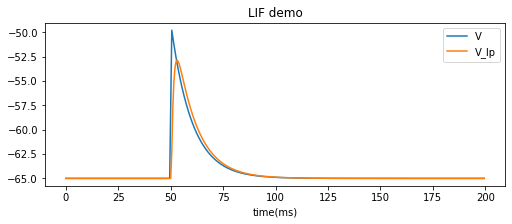

In [6]:
## LIF
tau_V = 0.5
t_duration = 200
idx_duration = int(t_duration/dt)
input_I = bp.ops.zeros(idx_duration)
idx_spike = int(50/dt)
idx_spike_duration = int(1/dt)
input_I[idx_spike: idx_spike+idx_spike_duration] = 160

lif = LIF(size=1, monitors=['V','V_lp']) # size is the iteration rounds
lif.run(duration=t_duration, inputs=('input', input_I)) # duration is the real time

# plot
fig, gs = bp.visualize.get_figure(row_num=1, col_num=1, row_len=3, col_len=7)

fig.add_subplot(gs[0, 0])
plt.plot(lif.mon.ts, lif.mon.V[:, 0], label='V')
plt.plot(lif.mon.ts, lif.mon.V_lp[:, 0], label='V_lp')
plt.legend()
plt.title('LIF demo')
plt.xlabel('time(ms)')
print('max V:', max(lif.mon.V))

## Step2: build synapse and yynaptic plasticity based on NMDA & AMPA 


**NMDA $Ca^{2+}$ current**

$$
I_{Ca^{2+}}=(1-[Ca^{2+}])g_{nmda}(V_i-E_{nmda})
$$

In which $V$ is the membrane potentail and $E_{nmda}$ the reversal potential of the NMDA receptors. The term $g_{nmda}$ si controlled by the pre-synaptic activity through $P_{nmda}$ and the NMDA receptor $Mg^{2+}$ block through $\tilde{G}$。 The NMDa receptor conductance $g_{nmda}$ is thus given as:

$$
g_{nmda}=\bar{g}_{nmda}P_{nmda}\tilde{G}
$$

$P_{nmda}$ represents the probability of glutamate
binding to the post-synaptic NMDA receptors or, assuming
a large number of post-synaptic NMDA receptors, it is
equivalent to the number of NMDA receptors to which
glutamate is bound. $P_{nmda}$ is the product of two dynamical terms $P^{+}, P^{-}$ acconting for the fast rise($\tau^{+}=1.5ms$) and slow decay($\tau^{-}=152ms$), respectively.

$$
\frac{dP^{+}}{dt}=\frac{1-P^{+}}{\tau^{+}} + \delta_{pre}\alpha^{+}P^{+}\\
\frac{dP^{-}}{dt}=\frac{0-P^{-}}{\tau^{-}} + \delta_{pre}\alpha^{-}(1-P^{-})
$$

$\delta_{pre}=1$ at the time of a pre-synaptic spike and $\delta_{pre}=0$ otherwise. $\alpha^{+},\alpha^{-}$ determine the jump maded in response to pre-synaptic activity and are equivalent to the amount of neurtransmitter release.

The NMDA receptors are blocked by $Mg^{2+}$ at low
membrane potentials, thus the NMDA receptor conductance $g_{nmda}$ also depends on the voltage dependent unblocking. The effect og $Mg^{2+}$ block is given by the function $G(V)$

$$
G(V) = (1+\frac{[Mg^{2+}]}{3.56}\exp[-V/16.12])^{-1}
$$

This equation calculates the $Mg^{2+}$ block instantaneously, however it has been found that this is a non-instantaneous process. To account for the non-instantaneous blocking/unblocking a low-pass filtered version $\tilde{G}$ is used,

$$
\tau_{G}\frac{d\tilde{G}}{dt}=-\tilde{G} + G(V_i)
$$
$\tau_{G}$ will result in different STDP curves.

The calcium concentration is then given by

$$
\frac{d[Ca^{2+}]}{dt}=\frac{(1-[Ca^{2+}])-\alpha I_{Ca^{2+}}^{(i)}}{\tau_{[Ca^{2+}]}}
$$

This equation could possibly be extended to a case in
which interactions between multiple proximal synapses
are considered by some weighted summation of the
independent calcium concentrations. 

---

**AMPA receptors**

The phenomoenological variable $w_i$ captures the synaptic stregth of synapse i. The AMPAR conductance $g_{ampa}$ is given by:

$$
g_{ampa}=w_i \bar{g}_{ampa}P_{ampa}
$$

in which the interpretation of $P_{ampa}$ is the same as $P_{nmda}$ as used in the calculation of the NMDA receptor conductance. It follows the same dynamical equation as $P^{-}$, but with a time constant of $\tau_{ampa}=5.26ms$


In [7]:
class Synapse(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint # (method='exponential_euler')
  def integral(P_p, P_n, P_n_ampa, sim_G, c_Ca, w, A_f, A_s, t, I_Ca_h, V_lp, tau_G):
    dP_p = (1 - P_p) / tau_p
    dP_n = (0 - P_n) / tau_n
    dP_n_ampa = (0 - P_n_ampa) / tau_ampa
    G = 1 / ( 1 + Mg2/3.56 * np.exp(-V_lp/16.12) )
    dsim_G = (-sim_G + G) / tau_G
    dc_Ca = ( ( - c_Ca) - alpha *I_Ca_h ) / tau_Ca # revised the formula in paper
    P_nmda = P_p * P_n
    g_nmda = bar_g_nmda * P_nmda * sim_G
    I_Ca = (1 - c_Ca) * g_nmda * (V_lp - E_nmda)

    H1 = np.heaviside(np.abs(A_f)-phi_f, 0)
    H2 = np.heaviside(A_s-phi_s, 0)

    delta_I_Ca = (I_Ca - I_Ca_h) / dt
    dw = A_f*H1 - alpha_s*A_s*H2
    dA_f = (-A_f + alpha_Af*(1-A_f)*delta_I_Ca) / tau_f
    dA_s = (-A_s - (1 - A_s)*I_Ca) / tau_s

    return dP_p, dP_n, dP_n_ampa, dsim_G, dc_Ca, dw, dA_f, dA_s

  def __init__(self, pre, post, conn, tau_G=20., **kwargs):
    super(Synapse, self).__init__(pre=pre, post=post, **kwargs)
    # parameters
    self.tau_G = tau_G

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.P_p = bp.ops.ones(self.size)
    self.P_n = bp.ops.zeros(self.size)
    self.P_n_ampa = bp.ops.zeros(self.size)
    self.G = bp.ops.zeros(self.size)
    self.sim_G = bp.ops.ones(self.size) * 1 / ( 1 + Mg2/3.56 * np.exp(-E_L/16.12) )
    self.c_Ca = bp.ops.zeros(self.size)
    self.g_nmda = bp.ops.zeros(self.size)
    self.g_ampa = bp.ops.zeros(self.size)
    self.I_Ca = bp.ops.zeros(self.size)
    self.w = bp.ops.zeros(self.size)
    self.A_f = bp.ops.zeros(self.size)
    self.A_s = bp.ops.zeros(self.size)

  def update(self, _t):
    for i in range(self.size):
      pre_id, post_id = self.pre_ids[i], self.post_ids[i]
      # update
      P_p, P_n, P_n_ampa, self.sim_G[i], self.c_Ca[i], self.w[i], self.A_f[i], self.A_s[i] = self.integral(self.P_p[i], 
      self.P_n[i], self.P_n_ampa[i], self.sim_G[i], self.c_Ca[i], self.w[i], 
      self.A_f[i], self.A_s[i], _t, self.I_Ca[i], self.post.V_lp[post_id], self.tau_G)
      if self.pre.spike[pre_id]:
        P_p += alpha_p * self.P_p[i]
        P_n += alpha_n * (1 - self.P_n[i])
        P_n_ampa += alpha_n * (1 - self.P_n_ampa[i])
      P_nmda = P_p * P_n
      P_ampa = P_p * P_n_ampa
      self.g_nmda[i] = bar_g_nmda * P_nmda * self.sim_G[i]
      self.g_ampa[i] = self.w[i] * bar_g_ampa * P_ampa
      self.I_Ca[i] = (1 - self.c_Ca[i]) * self.g_nmda[i] * (self.post.V_lp[post_id] - E_nmda)
      self.P_p[i] = P_p
      self.P_n[i] = P_n
      self.P_n_ampa[i] = P_n_ampa
      self.G[i] = 1 / ( 1 + Mg2/3.56 * np.exp(-self.post.V_lp[post_id]/16.12) )

      # output
      self.post.g_nmda[post_id] = self.g_nmda[i]
      self.post.g_ampa[post_id] = self.g_ampa[i]

**Synaptic plasticity**

the change in $w_i$ will be governed by both the magnitude and the time evolution of the $Ca^{2+}$ current. The synaptic weight changes are calculated from two signals that are derived a fast signal $A_f$ which will determine the main shape of the STDP window and a slow signal $A_s$ that will center the STDP curve around zero:

$$
\Delta w_i = A_f\Theta (|A_f|-\varphi_f)-\alpha_s A_s \Theta(A_s-\varphi_s)
$$

where $\Theta$ is the Heaviside step function and $\varphi_f, \varphi_s$ are thresholds to ensure that below a certain level no synaptic changes occur. The scaling factor $\alpha_s$ determins the amount in which $A_s$ influences the resultant synaptic change, in effect it determines to what extend the STDP window is shifted downwards. The weight update in above equation may seem rather un-biopysical, considering existing models.

However, this study is to propose a STDP mechanism that does not depend on the $Ca^{2+}$ concentration, but rather takes experimental observations into account that show the importance of the dynamics of the $Ca^{2+}$ current.

**Therefore we propose a signal that is derived from the $Ca^{2+}$ dynamics, is consistent with experimental data, and results in the same synaptic changes.**

The difference in time scale of the two signals is
motivated by the observation that spike-timing-dependent
LTP involves fast signalling and spike-timing-dependent
LTD depends on a slower timescale. The slow signal $A_s$ can be seen as the $[Ca^{2+}]$ in the spine that remains after the initial transient and is thus directly derived from the $Ca^{2+}$ currenct $I_{Ca^{2++}}$:

$$
\tau_s\frac{dA_s}{dt}=-A_s-(1-A_s)I_{Ca^{2+}}
$$

The signal $A_s$ evolves with a relatively slow time constant $\tau_s\approx 8ms$ and its peak is therefore attenuated, this, combined with the thresholding function of the Heaviside step function, makes that this signal acts to induce LTD for $Ca^{2+}$ levels above a certain threshold $\varphi_s$, similiar to the LTD part of the calcium control models. Above equation includes a saturation which does not qualitatively alter the results of the current simulation.

The main determinant for the shape of the STDP curve is the fast signal $A_f$, which acts on a time scale of $\tau_f\approx 3.5ms$. The aim was to make the synaptic change dependent on other factors than the peak or average $[Ca^{2+}]$ alone, by taking into account a term that depends on the time course of the $Ca^{2+}$ influx. As a simple initial the first time-difference of the $Ca^{2+}$ current is taken: $h\Delta I_{Ca^{2+}}=I_{Ca^{2+}}(t)-I_{Ca^{2+}}(t-h)$, with $h$ being the simulation timestep. The signal $A_f$ then follows:

$$
\tau_f\frac{dA_f}{dt} =-A_f+\alpha_{A_f}(1-A_f)\Delta I_{Ca^{2+}}
$$

The saturation here has a strong effect on the resulting synaptic change. The fast signal $A_f$, and with that the gross shape of the STDP curve, depends effectively on a low-pass filtered version, with a non-linearity due to the saturation, of the rate of change of $Ca^{2+}$ influx.


## Result

Text(0.5, 0, 'time(ms)')

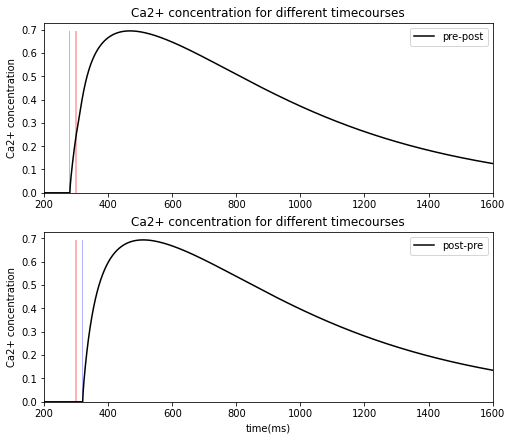

In [20]:
# Fig.3: Ca2+ concentration for different timecourses delta_t = -20/20 ms
alpha_p = 0.9
bar_g_nmda = 0.4 # origin value is 0.01, but it doesn't make sense in the paper
delta_T = [-20, 20]
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)
for i in range(2):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 1600
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(1/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 160
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 157

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['c_Ca'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  # plot
  ax = fig.add_subplot(gs[i, 0])
  plt.title('Ca2+ concentration for different timecourses')
  plt.plot(neu1.mon.ts, syn1.mon.c_Ca, label=Legend[i], color='k')
  plt.legend()
  # add ylabel
  ax.set_ylabel('Ca2+ concentration')
  # set axis lim
  plt.xlim(200, 1600)
  plt.ylim(0, )
  # note the pre/post firing
  plt.fill_between([300-2,300+2],max(syn1.mon.c_Ca[:,0]),facecolor='r',alpha=0.3)
  plt.fill_between([300+delta_t-2,300+delta_t+2],max(syn1.mon.c_Ca[:,0]),facecolor='b',alpha=0.3)

plt.xlabel('time(ms)')

# tips：修改参数alpha_p从0.5到0.9，使得spike引起的P_nmda增大，达到文中效果

Text(0.5, 0, 'time(ms)')

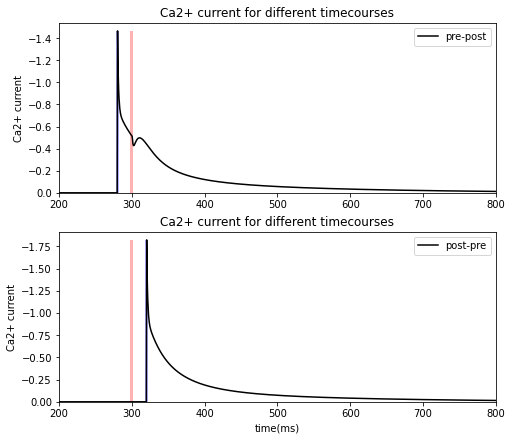

In [22]:
# Fig.4: Ca2+ current for different timecourses delta_t = -20/20 ms
alpha_p = 0.9 # 0.5
bar_g_nmda = 0.4 # origin value is 0.01, but it doesn't make sense in the paper
delta_T = [-20, 20]
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)
for i in range(2):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 1600
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(1/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 160
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 170

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['I_Ca'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  # plot
  ax = fig.add_subplot(gs[i, 0])
  plt.title('Ca2+ current for different timecourses')
  plt.plot(neu1.mon.ts, syn1.mon.I_Ca, label=Legend[i], color='k')
  ax.invert_yaxis()
  plt.legend()
  # add ylabel
  ax.set_ylabel('Ca2+ current')
  # set axis limit
  plt.xlim(200, 800)
  plt.ylim(0,)
  # note the pre/post firing
  plt.fill_between([300-2,300+2], min(syn1.mon.I_Ca[:,0]),facecolor='r',alpha=0.3)
  plt.fill_between([300+delta_t-2,300+delta_t+2], min(syn1.mon.I_Ca[:,0]),facecolor='b',alpha=0.3)

plt.xlabel('time(ms)')

# 修改参数alpha_p从0.5到0.9， 修改bar_g_nmda从0.01到0.4以满足I_Ca的量纲大小，达到文中效果
# 个人认为文中的参数不足以达到其result中的效果

Text(0.5, 0, 'time(ms)')

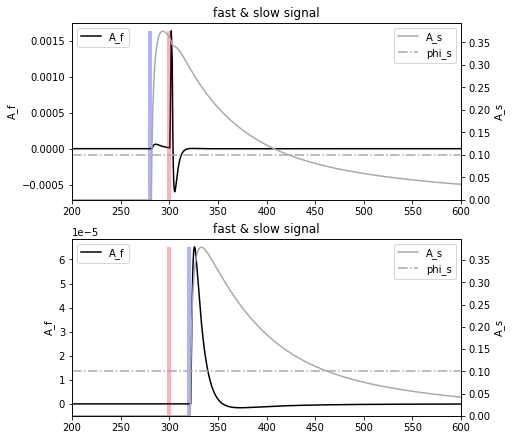

In [15]:
# Fig5: Fast (black lines) and slow (grey lines) plasticity signals delta_t = -20/20 ms

delta_T = [-20, 20]
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)
for i in range(2):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 1600
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(2/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 100
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 100

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['A_f','A_s'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  # plot
  ax = fig.add_subplot(gs[i, 0])
  plt.title('fast & slow signal')
  plt.plot(neu1.mon.ts, syn1.mon.A_f, label='A_f', color='k')
  ax.set_ylabel('A_f')
  plt.legend(loc='best')
  plt.legend(loc='upper left')
  
  ax1 = ax.twinx()
  ax1.set_ylabel(('A_s'))
  plt.plot(neu1.mon.ts, syn1.mon.A_s, label='A_s', color='darkgrey')
  plt.plot(neu1.mon.ts, 0.1*bp.ops.ones(idx_duration), '-.', label='phi_s', color='darkgrey')
  plt.legend(loc='upper right')

  # set axis lim
  plt.xlim(200, 600)
  plt.ylim(0,)
  # note the pre/post firing
  plt.fill_between([300-2,300+2], max(syn1.mon.A_s[:,0]),facecolor='r',alpha=0.3)
  plt.fill_between([300+delta_t-2,300+delta_t+2], max(syn1.mon.A_s[:,0]),facecolor='b',alpha=0.3)

plt.xlabel('time(ms)')

# 0-0.04，0-1.2 幅度数量级暂时不对
# post-pre整体趋势相同
# pre-post中post刺激强于pre刺激，趋势不同，可能与修改g_nmda有关

Text(0.5, 0, 't_pre-t_post')

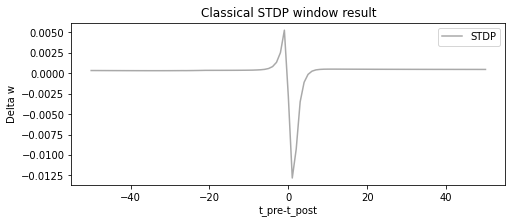

In [16]:
# Fig.6: Classical STDP window resulting from the simulation of the classical STDP induction protocol with the proposed model. delt_T = -100 - 100

delta_T = [x-50 for x in range(101)]
Delta_w = []
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(1, 1, 3, 7)
for i in range(len(delta_T)):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 800
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(2/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 100
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 100

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['w'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  Delta_w.append(syn1.mon.w[-1]-syn1.mon.w[0])

# plot
ax = fig.add_subplot(gs[0, 0])
plt.title('Classical STDP window result')
plt.plot(delta_T, Delta_w, label='STDP', color='darkgrey')
plt.legend()
# add ylabel
ax.set_ylabel('Delta w')

plt.xlabel('t_pre-t_post')

# 没有太理解原文中纵坐标的含义，这里直接取某次实验中，权重w的改变值积累量为纵坐标
# 两侧不太对称，可能与纵坐标含义和参数设置有关

Text(0.5, 0, 'time(ms)')

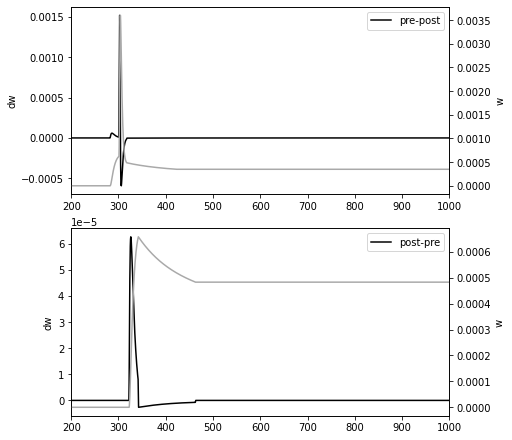

In [17]:
# Fig.7: Synaptic change versus time delta_t = -20/20 ms

delta_T = [-20, 20]
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)
for i in range(2):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 1600
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(2/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 100
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 100

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['w'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  # plot
  ax = fig.add_subplot(gs[i, 0])
  plt.plot(neu1.mon.ts, np.gradient(syn1.mon.w[:,0])/dt, label=Legend[i], color='k')
  plt.legend()
  # add ylabel
  ax.set_ylabel('dw')
  # set axis lim
  plt.xlim(200, 1000)

  ax1 = ax.twinx()
  ax1.set_ylabel(('w'))
  plt.plot(neu1.mon.ts, syn1.mon.w[:,0], label=Legend[i], color='darkgrey')

  # note the pre/post firing
  plt.fill_between([300-2,300+2], min(syn1.mon.w[:,0]),facecolor='r',alpha=0.3)
  plt.fill_between([300+delta_t-2,300+delta_t+2], min(syn1.mon.w[:,0]),facecolor='blue',alpha=0.3)

plt.xlabel('time(ms)')

# 0-0.04， 0-1.5 量级暂时不对
# w的最终值偏差较大

## Next Step

1. 复现调参如何保证生物学意义？
2. 学习的正向传递过程，如何使用STDP？（暂时的想法：（分层）+时序）
3. 网络权重w更新如何体现在网络中？（发育，可能与g_ampa有关）
4. ...